In [1]:
import pandas as pd

In [2]:
data_path = '/content/drive/MyDrive/Colab Notebooks/LSTM_CNN_data.csv'
origin_data = pd.read_csv(data_path)

In [ ]:
origin_data.head()

,도서ID,대출일자,수서방법,주류,강목,소장위치,대출년도
0,SS_143820,1970-01-01,수서정보없음,문학,문학,1,1970
1,SS_193930,1970-01-01,수서정보없음,언어,언어,1,1970
2,SS_193929,1970-01-01,수서정보없음,언어,언어,1,1970
3,SS_129237,1970-01-01,학과신청,언어,기타제어,0,1970
4,SS_044379,1970-01-01,사서선정,철학,"인식론,인과론,인간학",1,1970


In [ ]:
len(origin_data)

1056987

In [7]:
!pip install tensorflow
!pip install scikit-learn


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# '소장위치', '주류', '강목'을 숫자형 레이블로 변환
label_encoder = LabelEncoder()

data['소장위치'] = label_encoder.fit_transform(origin_data['소장위치'])
data['주류'] = label_encoder.fit_transform(origin_data['주류'])
data['강목'] = label_encoder.fit_transform(origin_data['강목'])

# LSTM 모델을 위한 데이터 변환
X = data[['대출년도', '주류', '강목']].values
y = data['소장위치'].values

# 시퀀스 데이터 생성
def create_sequences(X, y, seq_length=10):
    sequences = []
    labels = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i+seq_length])
        labels.append(y[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

# 데이터 형태 확인
print(X_seq.shape, y_seq.shape)


(1056977, 10, 3) (1056977,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense

# 모델 구성
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 출력층 수정

# 모델 컴파일 (이진 분류용)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 10, 64)              │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 8, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,241 (149.38 KB)

 Trainable params: 38,241 (149.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 훈련
model.fit(X_seq, y_seq, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
26425/26425 ━━━━━━━━━━━━━━━━━━━━ 195s 7ms/step - accuracy: 0.5682 - loss: 0.6840 - val_accuracy: 0.8448 - val_loss: 0.6084
Epoch 2/10
26425/26425 ━━━━━━━━━━━━━━━━━━━━ 186s 7ms/step - accuracy: 0.5691 - loss: 0.6836 - val_accuracy: 0.8448 - val_loss: 0.6083
Epoch 3/10
26425/26425 ━━━━━━━━━━━━━━━━━━━━ 205s 7ms/step - accuracy: 0.5690 - loss: 0.6836 - val_accuracy: 0.8448 - val_loss: 0.6120
Epoch 4/10
26425/26425 ━━━━━━━━━━━━━━━━━━━━ 200s 7ms/step - accuracy: 0.5697 - loss: 0.6834 - val_accuracy: 0.8448 - val_loss: 0.6047
Epoch 5/10
26425/26425 ━━━━━━━━━━━━━━━━━━━━ 204s 7ms/step - accuracy: 0.5690 - loss: 0.6836 - val_accuracy: 0.8448 - val_loss: 0.6021
Epoch 6/10
26425/26425 ━━━━━━━━━━━━━━━━━━━━ 206s 7ms/step - accuracy: 0.5698 - loss: 0.6834 - val_accuracy: 0.8448 - val_loss: 0.6066
Epoch 7/10
26425/26425 ━━━━━━━━━━━━━━━━━━━━ 191s 7ms/step - accuracy: 0.5685 - loss: 0.6838 - val_accuracy: 0.8448 - val_loss: 0.6085
Epoch 8/10
26425/26425 ━━━━━━━━━━━━━━━━━━━━ 205s 7ms/step - ac

In [ ]:
# 모델 평가
loss, accuracy = model.evaluate(X_seq, y_seq)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

33031/33031 ━━━━━━━━━━━━━━━━━━━━ 107s 3ms/step - accuracy: 0.4883 - loss: 0.7054
Test Loss: 0.6686738729476929, Test Accuracy: 0.6242151260375977


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 모델 예측 (validation 데이터나 test 데이터 사용)
y_pred = model.predict(model.X_val)  # X_val은 검증 데이터
y_pred = (y_pred > 0.5).astype(int)  # 이진 분류일 경우 확률을 0.5 기준으로 이진화

# 실제 값 (y_val은 검증 데이터의 실제 값)
y_true = y_val

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['True Class 0', 'True Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'model' is not defined

아아앙ㄱ 다시!!!!!!!!!!!!!!!!!!!1

In [4]:
from sklearn.preprocessing import LabelEncoder

# 연도별 대출 횟수 카운트
yearly_data = origin_data.groupby(['도서ID', '대출년도']).size().unstack(fill_value=0)

# 2. 주류와 강목 범주형 데이터 라벨 인코딩
label_encoder = LabelEncoder()
origin_data['주류'] = label_encoder.fit_transform(origin_data['주류'])
origin_data['강목'] = label_encoder.fit_transform(origin_data['강목'])
origin_data['수서방법'] = label_encoder.fit_transform(origin_data['수서방법'])

# 3. 주류, 강목, 대출횟수 포함한 최종 데이터 구성
final_data = origin_data.drop(['대출일자', '대출년도', '소장위치'], axis=1).drop_duplicates(subset=['도서ID'])
final_data = origin_data.set_index('도서ID')

# 4. 대출횟수 추가 (2004~2024년까지 각 연도별 대출 횟수)
final_data = final_data.join(yearly_data, on='도서ID')

# 5. 소장위치 추가
final_data['소장위치'] = origin_data.groupby('도서ID')['소장위치'].first()  # 첫 번째 소장위치를 가져오기

# 6. 최종 결과 출력
print(final_data.head())

                 대출일자  수서방법  주류  강목  소장위치  대출년도  1970  2004  2005  2006  ...  \
도서ID                                                                     ...   
SS_143820  1970-01-01     2   1  19     1  1970     1     0     0     0  ...   
SS_193930  1970-01-01     2   3  41     1  1970     1     0     0     0  ...   
SS_193929  1970-01-01     2   3  41     1  1970     1     0     0     0  ...   
SS_129237  1970-01-01     5   3   9     0  1970     1     0     0     0  ...   
SS_044379  1970-01-01     1   8  51     1  1970     1     0     0     0  ...   

           2015  2016  2017  2018  2019  2020  2021  2022  2023  2024  
도서ID                                                                   
SS_143820     0     0     0     0     0     0     0     0     0     0  
SS_193930     0     0     0     0     0     0     0     0     0     0  
SS_193929     0     0     0     0     0     0     0     0     0     0  
SS_129237     0     0     0     0     0     0     0     0     0     0  
SS_0443

In [ ]:
final_data.columns

Index(['수서방법',   '주류',   '강목',   1970,   2004,   2005,   2006,   2007,   2008,
         2009,   2010,   2011,   2012,   2013,   2014,   2015,   2016,   2017,
         2018,   2019,   2020,   2021,   2022,   2023,   2024, '소장위치'],
      dtype='object')

In [ ]:
len(final_data)

301151

In [ ]:
final_data.head()

,수서방법,주류,강목,1970,2004,2005,2006,2007,2008,2009,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,소장위치
도서ID,,,,,,,,,,,,,,,,,,,,,
SS_143820,2,1,19,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SS_193930,2,3,41,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SS_193929,2,3,41,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SS_129237,5,3,9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SS_044379,1,8,51,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
data = final_data.drop(["수서방법","주류","강목",1970],axis=1)

In [ ]:
data.head()

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,소장위치
도서ID,,,,,,,,,,,,,,,,,,,,,
SS_143820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SS_193930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SS_193929,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SS_129237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SS_044379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
data2 = final_data[["수서방법", "주류", "강목", "소장위치"]]

In [19]:
data2.head()

,수서방법,주류,강목,소장위치
도서ID,,,,
SS_143820,2,1,19,1
SS_193930,2,3,41,1
SS_193929,2,3,41,1
SS_129237,5,3,9,0
SS_044379,1,8,51,1


# MLP

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 입력 데이터를 벡터 형태로 준비
X = data.iloc[:, 1:-1].values  # 연도별 대출 횟수
y = data.iloc[:, -1].values    # 소장위치 (label)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MLP 모델 생성
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 레이블 개수에 따라 조정
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32)

# 평가
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


Epoch 1/20
6023/6023 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.6852 - loss: 0.5959 - val_accuracy: 0.6906 - val_loss: 0.5801
Epoch 2/20
6023/6023 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.6942 - loss: 0.5761 - val_accuracy: 0.6894 - val_loss: 0.5794
Epoch 3/20
6023/6023 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6935 - loss: 0.5764 - val_accuracy: 0.6913 - val_loss: 0.5810
Epoch 4/20
6023/6023 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.6913 - loss: 0.5753 - val_accuracy: 0.6915 - val_loss: 0.5781
Epoch 5/20
6023/6023 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.6935 - loss: 0.5733 - val_accuracy: 0.6917 - val_loss: 0.5785
Epoch 6/20
6023/6023 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6940 - loss: 0.5732 - val_accuracy: 0.6917 - val_loss: 0.5772
Epoch 7/20
6023/6023 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6932 - loss: 0.5722 - val_accuracy: 0.6917 - val_loss: 0.5788
Epoch 8/20
6023/6023 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6952 - loss: 0

#트리기반

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 데이터 준비
X = data.iloc[:, 1:-1].values  # 연도별 대출 횟수
y = data.iloc[:, -1].values    # 소장위치 (label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.69


# 트리기반 18~24년

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split # Import train_test_split


# 입력 데이터를 벡터 형태로 준비
X = data.iloc[:, 10:-1].values  # 연도별 대출 횟수
y = data.iloc[:, -1].values    # 소장위치 (label)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MLP 모델 생성
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 레이블 개수에 따라 조정
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

# 평가
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
21140/21140 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.8108 - loss: -21276.7051 - val_accuracy: 0.8448 - val_loss: -256528.4219
Epoch 2/10
21140/21140 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.8044 - loss: -538678.0625 - val_accuracy: 0.8391 - val_loss: -1639298.8750
Epoch 3/10
21140/21140 ━━━━━━━━━━━━━━━━━━━━ 92s 3ms/step - accuracy: 0.8041 - loss: -2401786.7500 - val_accuracy: 0.8383 - val_loss: -4983377.0000
Epoch 4/10
21140/21140 ━━━━━━━━━━━━━━━━━━━━ 71s 3ms/step - accuracy: 0.8039 - loss: -6686522.0000 - val_accuracy: 0.8402 - val_loss: -11096006.0000
Epoch 5/10
21140/21140 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.8038 - loss: -14325586.0000 - val_accuracy: 0.8310 - val_loss: -20787018.0000
Epoch 6/10
21140/21140 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.8042 - loss: -24624568.0000 - val_accuracy: 0.8383 - val_loss: -35009928.0000
Epoch 7/10
21140/21140 ━━━━━━━━━━━━━━━━━━━━ 73s 3ms/step - accuracy: 0.8046 - loss: -40256472.0000 - val_accuracy: 0.

In [14]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

6607/6607 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8374 - loss: -155470336.0000
Test Accuracy: 0.84


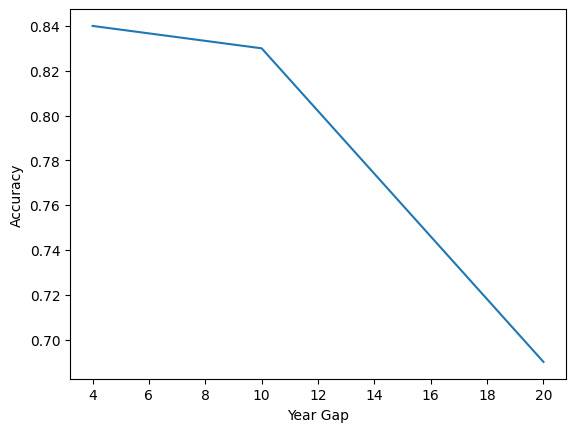

In [15]:
import matplotlib.pyplot as plt

plt.plot([20, 10, 4,], [0.69, 0.83, 0.84])
plt.xlabel("Year Gap")
plt.ylabel("Accuracy")
plt.show()

# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 데이터 준비
X = data.iloc[:, 1:-1].values  # 연도별 대출 횟수
y = data.iloc[:, -1].values    # 소장위치 (label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest 모델 생성 및 학습
model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")


Test Accuracy: 0.68


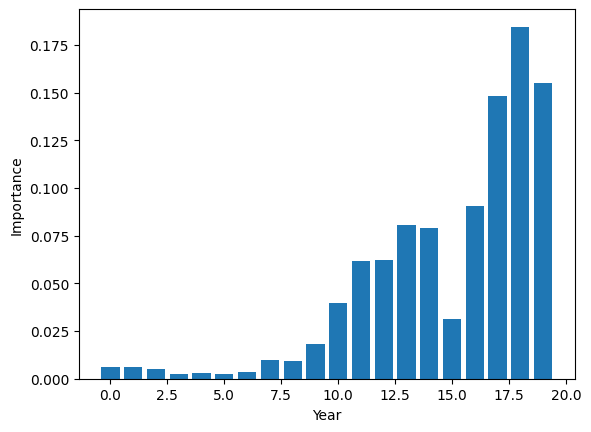

In [ ]:
import matplotlib.pyplot as plt

# 특성 중요도 시각화
importances = model.feature_importances_
plt.bar(range(len(importances)), importances)
plt.xlabel("Year")
plt.ylabel("Importance")
plt.show()


In [ ]:
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


# 수서방법, 주류, 강목의 영향도

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (32.1 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124950 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
훈련 데이터 정확도: 0.7714


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

테스트 데이터 정확도: 0.7692


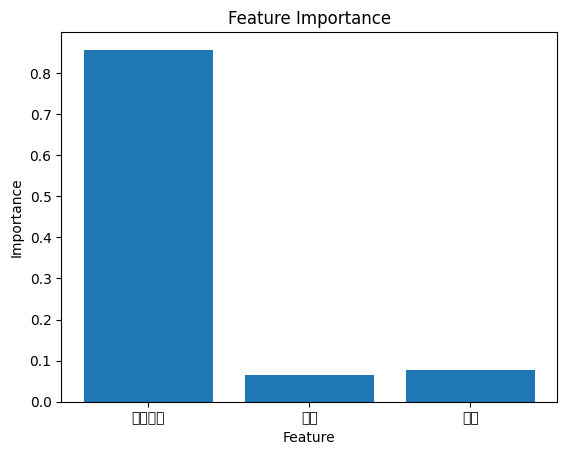

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 독립변수(X)와 종속변수(y) 설정
X = data[['수서방법'] + years ]
y = data['소장위치']

# 데이터셋을 훈련용과 테스트용으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 분류 모델 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 모델 성능 평가
print(f"훈련 데이터 정확도: {model.score(X_train, y_train):.4f}")
print(f"테스트 데이터 정확도: {model.score(X_test, y_test):.4f}")

# 평가
y_pred = model.predict(new_data)

# 특성 중요도 확인
feature_importances = model.feature_importances_

# 중요도 시각화
plt.bar(X.columns, feature_importances)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
# 수서방법과 다른 변수들 간의 상관관계
correlation = data2.corr()
print(correlation)


          수서방법        주류        강목      소장위치
수서방법  1.000000 -0.005662  0.013845 -0.220058
주류   -0.005662  1.000000  0.218648  0.038023
강목    0.013845  0.218648  1.000000  0.028202
소장위치 -0.220058  0.038023  0.028202  1.000000


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

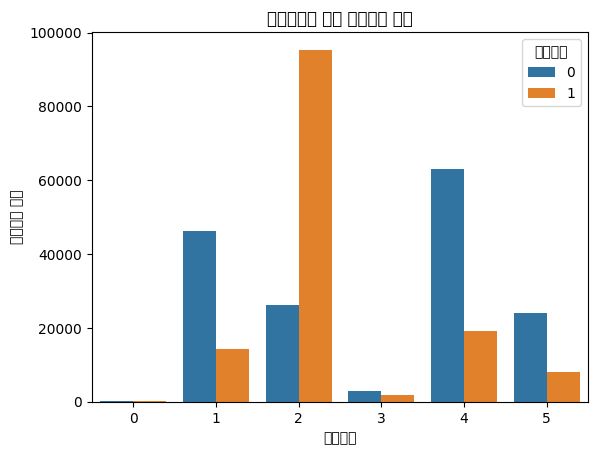

In [ ]:
import seaborn as sns

# 수서방법과 소장위치의 관계를 시각화
sns.countplot(data=data2, x='수서방법', hue='소장위치')
plt.xlabel('수서방법')
plt.ylabel('소장위치 분포')
plt.title('수서방법에 따른 소장위치 분포')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# '수서방법' 컬럼에 대한 레이블 인코딩
encoded_labels = label_encoder.fit_transform(origin_data['수서방법'])

# 인코딩된 값과 원본 값 간의 매핑 확인
mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(mapping)


{'기타': 0, '사서선정': 1, '수서정보없음': 2, '수업지정': 3, '이용자희망': 4, '학과신청': 5}


1 : 보존서고, 0 : 4층인문

<ipython-input-85-990f23ce213b>:23: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-85-990f23ce213b>:23: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-85-990f23ce213b>:23: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-85-990f23ce213b>:23: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-85-990f23ce213b>:23: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-85-990f23ce213b>:23: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-85-990f23ce213b>:23: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ip

소장위치  소장위치_0_비율  소장위치_1_비율
수서방법                      
0      0.655914   0.344086
1      0.764053   0.235947
2      0.215552   0.784448
3      0.602342   0.397658
4      0.767291   0.232709
5      0.750482   0.249518


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48277 (\N{HANGUL SYLLABLE BEOB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/u

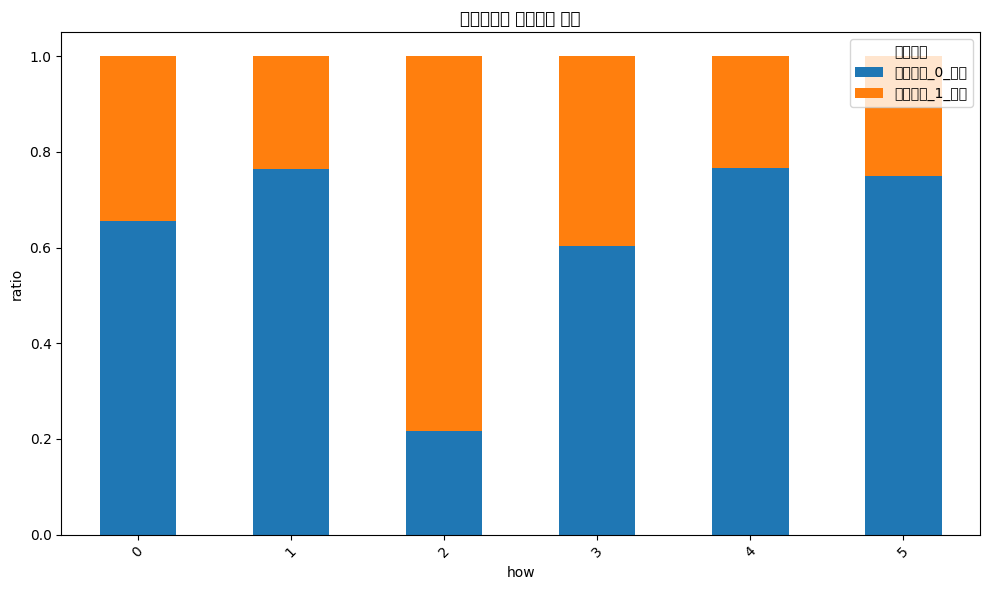

In [ ]:
# 수서방법별 소장위치 비율 계산
pivot_df = data2.groupby(['수서방법', '소장위치']).size().unstack().fillna(0)
pivot_df['total'] = pivot_df.sum(axis=1)
pivot_df['소장위치_0_비율'] = pivot_df[0] / pivot_df['total']
pivot_df['소장위치_1_비율'] = pivot_df[1] / pivot_df['total']

print(pivot_df[['소장위치_0_비율', '소장위치_1_비율']])

import matplotlib.pyplot as plt

# '소장위치_0_비율'과 '소장위치_1_비율'에 대한 bar plot 그리기
pivot_df[['소장위치_0_비율', '소장위치_1_비율']].plot(kind='bar', stacked=True, figsize=(10, 6))

# 제목과 레이블 추가
plt.title('수서방법별 소장위치 비율')
plt.xlabel('how')
plt.ylabel('ratio')

# x축 레이블 회전
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()
plt.show()


In [ ]:
# 수서방법과 소장위치 간의 교차 분석
cross_tab = pd.crosstab(data2['수서방법'], data2['소장위치'])
print(cross_tab)


소장위치      0      1
수서방법              
0       183     96
1     46132  14246
2     26210  95385
3      2778   1834
4     63023  19114
5     24128   8022


1970 년도 빼고 해야 함! 다시 하기!

1. 대출회수가 적은 걸 내리는 게 맞나?
책에 대한 정보를 3년단위로(04-06) -> 다음 3년 예측(07-09) ==> 대출양이 많을 것이라고 판단되면 냅두고, 아니면 내리고 : 말은 이해함!!!!!!! ==> 최종적으로 소장위치와 연관이 있는지 봐야 하는데
+ 대출은 안되지만 4층에 계속 있는 애들을 잡아낼 수 없음

2. 비시계열과 시계열 분리해서 다시 해보께 (1970제외하고)
시퀀스 길이 조절도 해보께

# **sequence = 10**

In [ ]:
# 년도별 대출여부를 특성에 추가
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# 특징
X = final_data[ years].values

# 타겟(소장위치)
y = final_data['소장위치'].values

# LSTM 모델을 위한 시퀀스 데이터 생성
def create_sequences(X, y, seq_length=10):
    sequences = []
    labels = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i+seq_length])
        labels.append(y[i+seq_length])
    return np.array(sequences), np.array(labels)

# 시퀀스 생성
seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

# 데이터 형태 확인
print(X_seq.shape, y_seq.shape)

(301141, 10, 21) (301141,)


In [ ]:
# 모델 구축
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense

model_10 = Sequential()
model_10.add(LSTM(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model_10.add(Conv1D(32, 3, activation='relu'))
model_10.add(MaxPooling1D(2))
model_10.add(Conv1D(64, 3, activation='relu'))
model_10.add(MaxPooling1D(2))
model_10.add(Flatten())
model_10.add(Dense(128, activation='relu'))
model_10.add(Dense(1, activation='sigmoid'))  # 이진 분류이므로 sigmoid 사용

model_10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_10.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 8, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 2, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,849 (167.38 KB)

 Trainable params: 42,849 (167.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터셋 분리: Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_seq, y_seq, test_size=0.3, random_state=42
)

# Temp 데이터셋을 다시 Validation (15%)와 Test (15%)로 분리
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# 데이터 분리 확인
print(f"Train 데이터: {X_train.shape}, {y_train.shape}")
print(f"Validation 데이터: {X_val.shape}, {y_val.shape}")
print(f"Test 데이터: {X_test.shape}, {y_test.shape}")

# 모델 훈련
history = model_10.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Train 데이터: (210798, 10, 21), (210798,)
Validation 데이터: (45171, 10, 21), (45171,)
Test 데이터: (45172, 10, 21), (45172,)
Epoch 1/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - accuracy: 0.6811 - loss: 0.5983 - val_accuracy: 0.6790 - val_loss: 0.6016
Epoch 2/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - accuracy: 0.6816 - loss: 0.5966 - val_accuracy: 0.6786 - val_loss: 0.6019
Epoch 3/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - accuracy: 0.6813 - loss: 0.5965 - val_accuracy: 0.6780 - val_loss: 0.6026
Epoch 4/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.6844 - loss: 0.5934 - val_accuracy: 0.6759 - val_loss: 0.6053
Epoch 5/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.6853 - loss: 0.5914 - val_accuracy: 0.6766 - val_loss: 0.6059
Epoch 6/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.6871 - loss: 0.5911 - val_accuracy: 0.6769 - val_loss: 0.6111
Epoch 7/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 87s 9ms/step - accuracy: 0.6909 - loss: 0.5856 - val_ac

In [ ]:
# 최종 평가 (Test Set)
loss, accuracy = model_10.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


1412/1412 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6740 - loss: 0.6159
Test Loss: 0.616325318813324, Test Accuracy: 0.6728504300117493


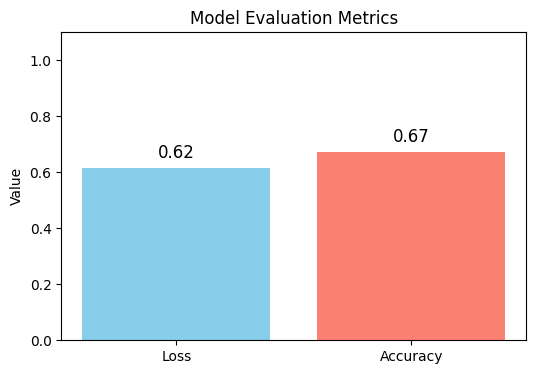

In [ ]:
import matplotlib.pyplot as plt

# 평가 결과 저장 (예제 데이터)
evaluation_metrics = {"Loss": loss, "Accuracy": accuracy}

# 시각화
def visualize_evaluation_metrics(metrics):
    plt.figure(figsize=(6, 4))

    # 막대 그래프 그리기
    plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'salmon'])

    # 그래프 꾸미기
    plt.title("Model Evaluation Metrics")
    plt.ylabel("Value")
    plt.ylim(0, 1.1)  # 값의 범위를 0~1로 제한
    for key, value in metrics.items():
        plt.text(key, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

    plt.show()

# Loss와 Accuracy 시각화
visualize_evaluation_metrics(evaluation_metrics)

1412/1412 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


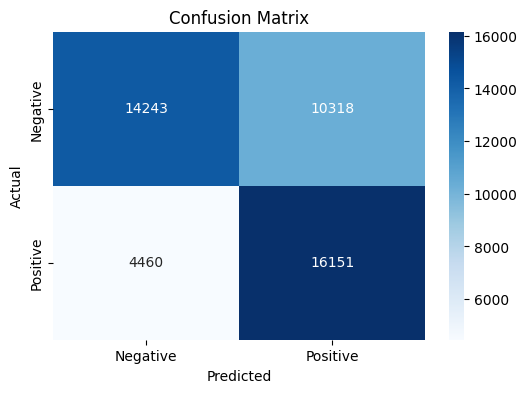

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 수행
y_pred = model_10.predict(X_test)

# 예측을 이진 분류로 변환 (확률을 0 또는 1로 변환)
y_pred_class = (y_pred > 0.5).astype(int)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_class)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# seqeunce = 5

In [ ]:
import numpy as np
# 년도별 대출여부를 특성에 추가
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# 특징
X = final_data[ years].values

# 타겟(소장위치)
y = final_data['소장위치'].values

# LSTM 모델을 위한 시퀀스 데이터 생성
def create_sequences(X, y, seq_length=5):
    sequences = []
    labels = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i+seq_length])
        labels.append(y[i+seq_length])
    return np.array(sequences), np.array(labels)

# 시퀀스 생성
seq_length = 5
X_seq, y_seq = create_sequences(X, y, seq_length)

# 데이터 형태 확인
print(X_seq.shape, y_seq.shape)

(301146, 5, 21) (301146,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense

model_5 = Sequential()
model_5.add(LSTM(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model_5.add(Conv1D(32, 3, activation='relu', padding="same"))  # 패딩 추가
model_5.add(MaxPooling1D(2))  # 첫 번째 MaxPooling1D
model_5.add(Conv1D(64, 2, activation='relu', padding="same"))  # 커널 크기 2와 패딩 추가
model_5.add(GlobalAveragePooling1D())  # 시퀀스 차원을 축소
model_5.add(Dense(128, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))  # 이진 분류

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_5.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 5, 64)               │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 5, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,801 (159.38 KB)

 Trainable params: 40,801 (159.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_5.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 5, 64)               │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 5, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 2, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,801 (159.38 KB)

 Trainable params: 40,801 (159.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터셋 분리: Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_seq, y_seq, test_size=0.3, random_state=42
)

# Temp 데이터셋을 다시 Validation (15%)와 Test (15%)로 분리
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# 데이터 분리 확인
print(f"Train 데이터: {X_train.shape}, {y_train.shape}")
print(f"Validation 데이터: {X_val.shape}, {y_val.shape}")
print(f"Test 데이터: {X_test.shape}, {y_test.shape}")

# 모델 훈련
history = model_5.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Train 데이터: (210802, 5, 21), (210802,)
Validation 데이터: (45172, 5, 21), (45172,)
Test 데이터: (45172, 5, 21), (45172,)
Epoch 1/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step - accuracy: 0.6736 - loss: 0.6089 - val_accuracy: 0.6792 - val_loss: 0.6041
Epoch 2/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.6775 - loss: 0.6042 - val_accuracy: 0.6788 - val_loss: 0.6047
Epoch 3/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.6797 - loss: 0.6012 - val_accuracy: 0.6793 - val_loss: 0.6021
Epoch 4/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.6785 - loss: 0.6023 - val_accuracy: 0.6795 - val_loss: 0.6017
Epoch 5/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.6812 - loss: 0.6006 - val_accuracy: 0.6793 - val_loss: 0.6023
Epoch 6/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.6806 - loss: 0.6008 - val_accuracy: 0.6794 - val_loss: 0.6019
Epoch 7/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.6787 - loss: 0.6015 - val_accur

In [ ]:
# 모델 평가
loss, accuracy = model_5.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


1412/1412 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6772 - loss: 0.6030
Test Loss: 0.6026845574378967, Test Accuracy: 0.6775878667831421


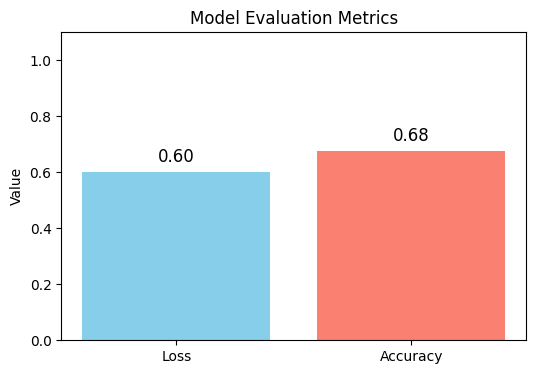

In [ ]:
import matplotlib.pyplot as plt

# 평가 결과 저장 (예제 데이터)
evaluation_metrics = {"Loss": loss, "Accuracy": accuracy}

# 시각화
def visualize_evaluation_metrics(metrics):
    plt.figure(figsize=(6, 4))

    # 막대 그래프 그리기
    plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'salmon'])

    # 그래프 꾸미기
    plt.title("Model Evaluation Metrics")
    plt.ylabel("Value")
    plt.ylim(0, 1.1)  # 값의 범위를 0~1로 제한
    for key, value in metrics.items():
        plt.text(key, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

    plt.show()

# Loss와 Accuracy 시각화
visualize_evaluation_metrics(evaluation_metrics)

1412/1412 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


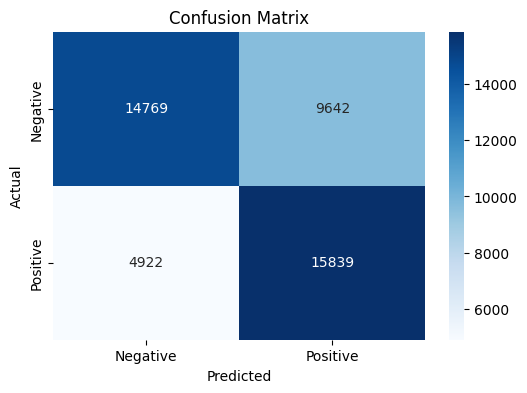

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 수행
y_pred = model_5.predict(X_test)

# 예측을 이진 분류로 변환 (확률을 0 또는 1로 변환)
y_pred_class = (y_pred > 0.5).astype(int)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_class)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# sequence = 3

In [ ]:
# 년도별 대출여부를 특성에 추가
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# 특징
X = final_data[ years].values

# 타겟(소장위치)
y = final_data['소장위치'].values

# LSTM 모델을 위한 시퀀스 데이터 생성
def create_sequences(X, y, seq_length=3):
    sequences = []
    labels = []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i+seq_length])
        labels.append(y[i+seq_length])
    return np.array(sequences), np.array(labels)

# 시퀀스 생성
seq_length = 3
X_seq, y_seq = create_sequences(X, y, seq_length)

# 데이터 형태 확인
print(X_seq.shape, y_seq.shape)

(301148, 3, 21) (301148,)


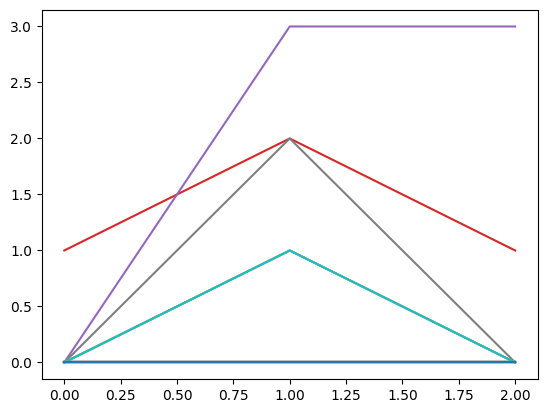

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_seq[261152])  # 샘플 하나의 시퀀스를 시각화
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model_3 = Sequential()
model_3.add(LSTM(64, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model_3.add(Conv1D(32, 3, activation='relu', padding="same"))  # padding="same" 추가
model_3.add(MaxPooling1D(2, padding="same"))  # padding="same" 추가
model_3.add(Conv1D(64, 3, activation='relu', padding="same"))  # padding="same" 추가
# MaxPooling1D를 필요에 따라 제거
model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))  # 이진 분류이므로 sigmoid 사용

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 3, 64)               │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 3, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 2, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,041 (199.38 KB)

 Trainable params: 51,041 (199.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터셋 분리: Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_seq, y_seq, test_size=0.3, random_state=42
)

# Temp 데이터셋을 다시 Validation (15%)와 Test (15%)로 분리
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# 데이터 분리 확인
print(f"Train 데이터: {X_train.shape}, {y_train.shape}")
print(f"Validation 데이터: {X_val.shape}, {y_val.shape}")
print(f"Test 데이터: {X_test.shape}, {y_test.shape}")

# 모델 훈련
history = model_3.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Train 데이터: (210803, 3, 21), (210803,)
Validation 데이터: (45172, 3, 21), (45172,)
Test 데이터: (45173, 3, 21), (45173,)
Epoch 1/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step - accuracy: 0.6670 - loss: 0.6150 - val_accuracy: 0.6785 - val_loss: 0.6016
Epoch 2/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - accuracy: 0.6788 - loss: 0.6037 - val_accuracy: 0.6791 - val_loss: 0.6031
Epoch 3/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.6794 - loss: 0.6028 - val_accuracy: 0.6791 - val_loss: 0.6024
Epoch 4/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.6802 - loss: 0.6014 - val_accuracy: 0.6792 - val_loss: 0.6021
Epoch 5/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 87s 9ms/step - accuracy: 0.6795 - loss: 0.6025 - val_accuracy: 0.6784 - val_loss: 0.6025
Epoch 6/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.6804 - loss: 0.6025 - val_accuracy: 0.6784 - val_loss: 0.6017
Epoch 7/10
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 53s 8ms/step - accuracy: 0.6779 - loss: 0.6033 - val_accur

In [ ]:
# 모델 평가
loss, accuracy = model_3.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


1412/1412 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6798 - loss: 0.6019
Test Loss: 0.6041913032531738, Test Accuracy: 0.6762003898620605


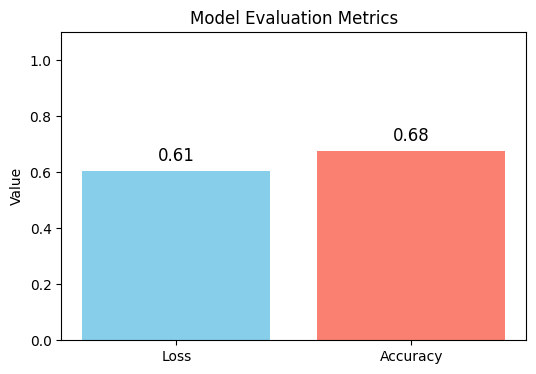

In [ ]:
import matplotlib.pyplot as plt

# 평가 결과 저장 (예제 데이터)
evaluation_metrics = {"Loss": loss, "Accuracy": accuracy}

# 시각화
def visualize_evaluation_metrics(metrics):
    plt.figure(figsize=(6, 4))

    # 막대 그래프 그리기
    plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'salmon'])

    # 그래프 꾸미기
    plt.title("Model Evaluation Metrics")
    plt.ylabel("Value")
    plt.ylim(0, 1.1)  # 값의 범위를 0~1로 제한
    for key, value in metrics.items():
        plt.text(key, value + 0.02, f"{value:.2f}", ha='center', va='bottom', fontsize=12)

    plt.show()

# Loss와 Accuracy 시각화
visualize_evaluation_metrics(evaluation_metrics)

1412/1412 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


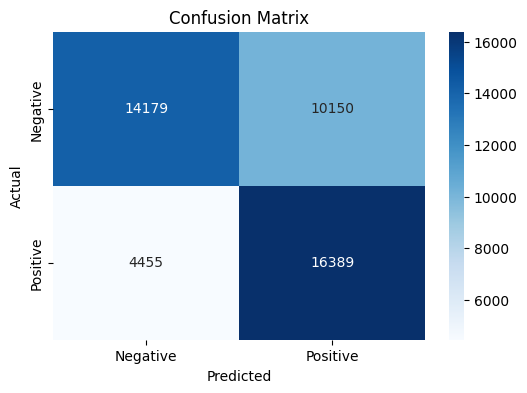

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 수행
y_pred = model_3.predict(X_test)

# 예측을 이진 분류로 변환 (확률을 0 또는 1로 변환)
y_pred_class = (y_pred > 0.5).astype(int)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_class)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

y_pred = (model_5.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


1412/1412 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.75      0.60      0.66     24329
           1       0.62      0.77      0.69     20844

    accuracy                           0.68     45173
   macro avg       0.69      0.68      0.68     45173
weighted avg       0.69      0.68      0.67     45173



In [ ]:
from sklearn.metrics import classification_report

y_pred = (model_3.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


1412/1412 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.58      0.66     24329
           1       0.62      0.79      0.69     20844

    accuracy                           0.68     45173
   macro avg       0.69      0.68      0.68     45173
weighted avg       0.69      0.68      0.67     45173



# 일단 끝

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# 1. 범주형 데이터 변환 (주류, 강목, 수서방법)
label_encoder_수서방법 = LabelEncoder()
final_data['수서방법'] = label_encoder_수서방법.fit_transform(final_data['수서방법'])

# 2. 년도별 대출여부 특성 준비
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# 3. 비시계열 특성 준비 (주류, 강목, 수서방법)
X_non_sequence = final_data[['수서방법']].values

# 4. 년도별 대출여부 데이터 준비 (시계열 특성)
X_time_series = final_data[years].values

# 5. 시계열 데이터를 위한 시퀀스 생성
def create_sequences(X_time_series, X_non_sequence, y, seq_length=10):
    sequences = []
    labels = []
    non_seq_data = []

    for i in range(len(X_time_series) - seq_length):
        sequences.append(X_time_series[i:i+seq_length])  # 시계열 데이터
        non_seq_data.append(X_non_sequence[i+seq_length])  # 비시계열 데이터 (각각의 인스턴스를 마지막에 배치)
        labels.append(y[i+seq_length])

    return np.array(sequences), np.array(non_seq_data), np.array(labels)

# 타겟(소장위치)
y = final_data['소장위치'].values

# 시퀀스 데이터 생성
seq_length = 10
X_seq_time_series, X_seq_non_sequence, y_seq = create_sequences(X_time_series, X_non_sequence, y, seq_length)

# 시퀀스 데이터 형태 확인
print(X_seq_time_series.shape, X_seq_non_sequence.shape, y_seq.shape)

(301141, 10, 21) (301141, 3) (301141,)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate

# LSTM 모델 입력 (시계열 데이터)
input_time_series = Input(shape=(seq_length, len(years)))

# 비시계열 데이터 입력 (수서방법)
input_non_sequence = Input(shape=(X_seq_non_sequence.shape[1],))

# LSTM 레이어
x = LSTM(64, return_sequences=True)(input_time_series)
x = Conv1D(64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

# 비시계열 데이터 연결
y = Dense(32, activation='relu')(input_non_sequence)

# 시계열 데이터와 비시계열 데이터 결합
combined = Concatenate()([x, y])

# 출력층
output = Dense(1, activation='sigmoid')(combined)

# 모델 생성
model = Model(inputs=[input_time_series, input_non_sequence], outputs=output)

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 10, 21)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 10, 64)         │         22,016 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 8, 64)          │         12,352 │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_10          │ (None, 4, 64)          │              0 │ conv1d_16[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 256)            │              0 │ max_pooling1d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 32)             │            128 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 288)            │              0 │ flatten_5[0][0],       │
│                           │                        │                │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 1)              │            289 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,785 (135.88 KB)

 Trainable params: 34,785 (135.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

# 훈련/검증/테스트 데이터 분리 (80% 훈련, 10% 검증, 10% 테스트)
X_train_time_series, X_temp_time_series, X_train_non_sequence, X_temp_non_sequence, y_train, y_temp = train_test_split(
    X_seq_time_series, X_seq_non_sequence, y_seq, test_size=0.2, random_state=42)

# 검증/테스트 데이터를 50%씩 나눔
X_val_time_series, X_test_time_series, X_val_non_sequence, X_test_non_sequence, y_val, y_test = train_test_split(
    X_temp_time_series, X_temp_non_sequence, y_temp, test_size=0.5, random_state=42)

# 데이터 분리 확인
print(f"Train 데이터: {X_train_time_series.shape}, {y_train.shape}")
print(f"Validation 데이터: {X_val_time_series.shape}, {y_val.shape}")
print(f"Test 데이터: {X_test_time_series.shape}, {y_test.shape}")


# 모델 훈련
model.fit([X_train_time_series, X_train_non_sequence], y_train, epochs=10, batch_size=32, validation_data=([X_val_time_series, X_val_non_sequence], y_val))

Train 데이터: (240912, 10, 21), (240912,)
Validation 데이터: (30114, 10, 21), (30114,)
Test 데이터: (30115, 10, 21), (30115,)
Epoch 1/10
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.7019 - loss: 0.5821 - val_accuracy: 0.7400 - val_loss: 0.5177
Epoch 2/10
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.7648 - loss: 0.5126 - val_accuracy: 0.7731 - val_loss: 0.5086
Epoch 3/10
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 56s 7ms/step - accuracy: 0.7649 - loss: 0.5121 - val_accuracy: 0.7630 - val_loss: 0.5115
Epoch 4/10
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.7668 - loss: 0.5113 - val_accuracy: 0.7719 - val_loss: 0.5071
Epoch 5/10
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.7690 - loss: 0.5088 - val_accuracy: 0.7679 - val_loss: 0.5070
Epoch 6/10
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.7683 - loss: 0.5089 - val_accuracy: 0.7724 - val_loss: 0.5086
Epoch 7/10
7529/7529 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.7689 - loss: 0.5074 - val_ac

In [ ]:
# 모델 평가
loss, accuracy = model.evaluate([X_test_time_series, X_test_non_sequence], y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


942/942 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7579 - loss: 0.5181
Test Loss: 0.5182180404663086, Test Accuracy: 0.7556034922599792


942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


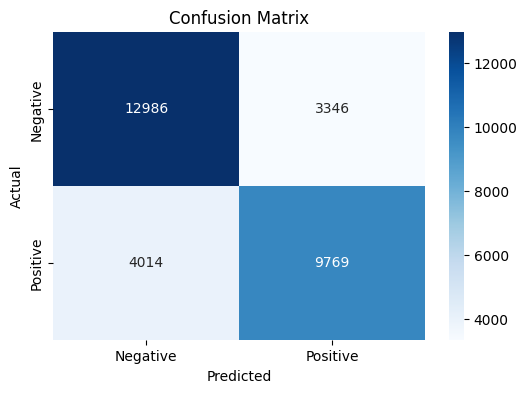

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 수행
y_pred = model.predict([X_test_time_series, X_test_non_sequence])

# 예측을 이진 분류로 변환 (확률을 0 또는 1로 변환)
y_pred_class = (y_pred > 0.5).astype(int)

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_class)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
cm

array([[12986,  3346],
       [ 4014,  9769]])

In [ ]:
from sklearn.metrics import classification_report

# 예측 수행
y_pred = model.predict([X_test_time_series, X_test_non_sequence])

# 예측값을 가장 확률이 높은 클래스로 변환 (이진 분류일 경우)
y_pred_class = np.argmax(y_pred, axis=1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


In [ ]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70     16332
           1       0.00      0.00      0.00     13783

    accuracy                           0.54     30115
   macro avg       0.27      0.50      0.35     30115
weighted avg       0.29      0.54      0.38     30115



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

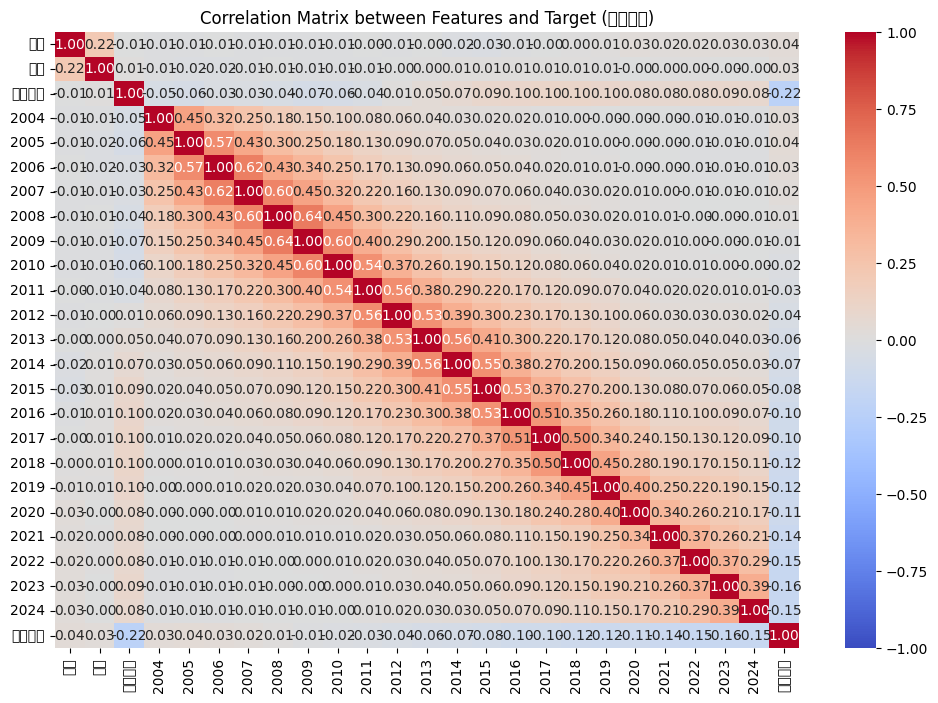

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 변수를 포함한 데이터프레임 준비
correlation_data = final_data[['주류', '강목', '수서방법'] + years + ['소장위치']]

# 상관 행렬 계산
correlation_matrix = correlation_data.corr()

# 상관 행렬 시각화 (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix between Features and Target (소장위치)')
plt.show()


In [ ]:
!apt-get -y install fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

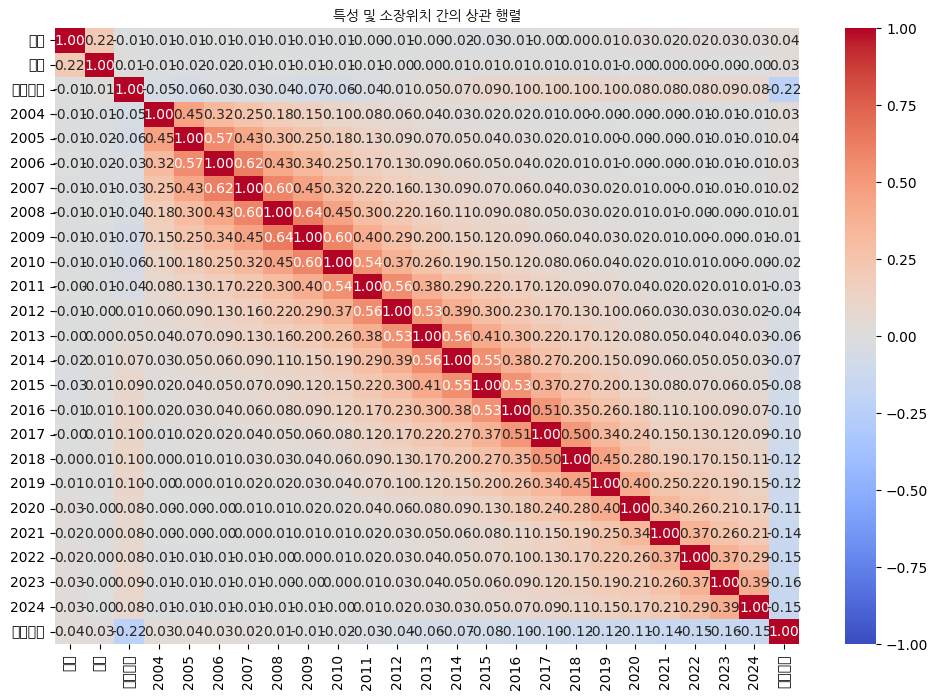

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

# 수치형 변수를 포함한 데이터프레임 준비
correlation_data = final_data[['주류', '강목', '수서방법'] + years + ['소장위치']]

# 상관 행렬 계산
correlation_matrix = correlation_data.corr()

# 상관 행렬 시각화 (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

# 제목에 한글 사용
plt.title('특성 및 소장위치 간의 상관 행렬', fontproperties=fontprop)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/

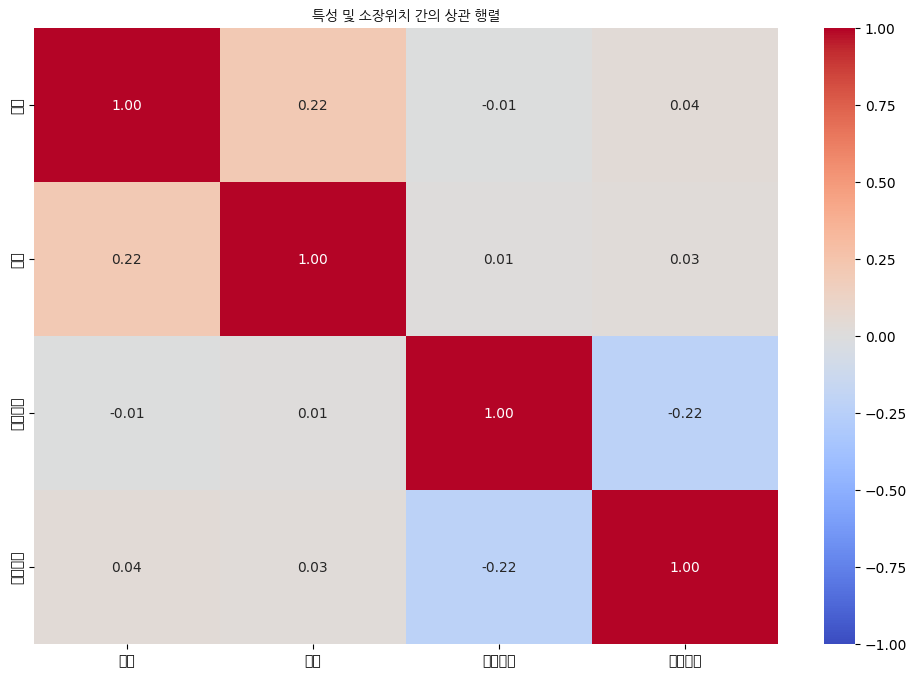

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

# 수치형 변수를 포함한 데이터프레임 준비
correlation_data = final_data[['주류', '강목', '수서방법', '소장위치']]

# 상관 행렬 계산
correlation_matrix = correlation_data.corr()

# 상관 행렬 시각화 (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

# 제목에 한글 사용
plt.title('특성 및 소장위치 간의 상관 행렬', fontproperties=fontprop)
plt.show()